# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
boston = pd.read_csv('../data/boston_data.csv')

In [3]:
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [4]:
boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')

- CRIM     per capita crime rate by town
- ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS    proportion of non-retail business acres per town
- CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX      nitric oxides concentration (parts per 10 million)
- RM       average number of rooms per dwelling
- AGE      proportion of owner-occupied units built prior to 1940
- DIS      weighted distances to five Boston employment centres
- RAD      index of accessibility to radial highways
- TAX      full-value property-tax rate per USD 10,000
- PTRATIO  pupil-teacher ratio by town
- B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT    % lower status of the population
- MEDV     Median value of owner-occupied homes in $1000's

In [5]:
boston.shape

(404, 14)

In [6]:
boston.dtypes

# all floats

crim       float64
zn         float64
indus      float64
chas       float64
nox        float64
rm         float64
age        float64
dis        float64
rad        float64
tax        float64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

In [7]:
boston.isna().sum()

# no nulls

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [8]:
boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.730912,10.509901,11.189901,0.069307,0.556710,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.053733,6.814909,0.254290,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.006320,0.000000,0.460000,0.000000,0.392000,3.56100,2.900000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,0.000000,0.453000,5.90275,45.800000,2.087875,4.000000,281.000000,17.375000,374.710000,7.135000,17.100000
50%,0.253715,0.000000,9.795000,0.000000,0.538000,6.23050,76.600000,3.207450,5.000000,330.000000,19.000000,391.065000,11.265000,21.400000
75%,4.053158,12.500000,18.100000,0.000000,0.631000,6.62925,94.150000,5.222125,24.000000,666.000000,20.200000,396.007500,16.910000,25.000000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.78000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.370000,50.000000


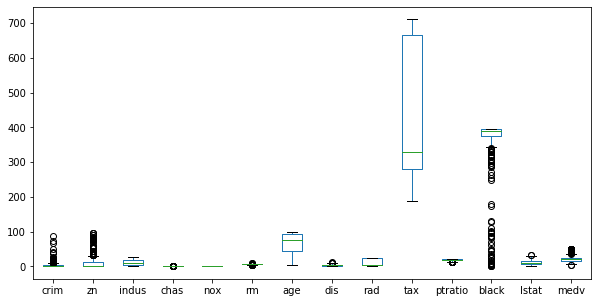

crim       10.396040
zn         12.128713
indus       0.000000
chas        6.930693
nox         0.000000
rm          5.198020
age         0.000000
dis         1.237624
rad         0.000000
tax         0.000000
ptratio     2.970297
black      15.099010
lstat       0.495050
medv        6.683168
dtype: float64

In [9]:
# Looking for outliers
boston.plot(kind = 'box', figsize = [10, 5])
plt.show()

Q1 = boston.quantile(0.25)
Q3 = boston.quantile(0.75)
IQR = Q3 - Q1

(((boston < (Q1 - 1.5 * IQR)) | (boston > (Q3 + 1.5 * IQR))).sum()) / boston.shape[0] * 100

# Too many outliers to be removed

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

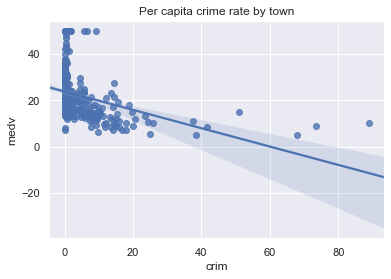

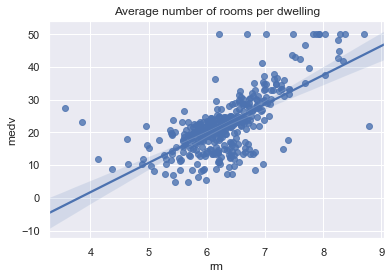

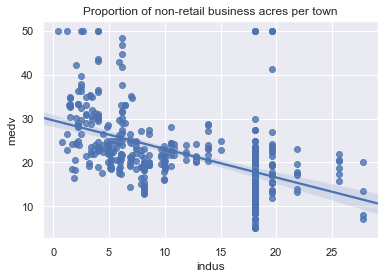

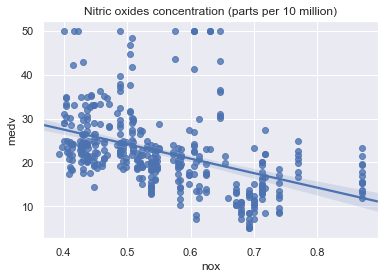

In [10]:
sns.set(color_codes=True)

# crim
sns.regplot(boston['crim'], boston['medv']).set_title('Per capita crime rate by town')
plt.show()

# rm
sns.regplot(boston['rm'], boston['medv']).set_title('Average number of rooms per dwelling')
plt.show()

# indus
sns.regplot(boston['indus'], boston['medv']).set_title('Proportion of non-retail business acres per town')
plt.show()

# nox
sns.regplot(boston['nox'], boston['medv']).set_title('Nitric oxides concentration (parts per 10 million)')
plt.show()

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [11]:
# I was expecting a higher relationship between the crime rate and the prices

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

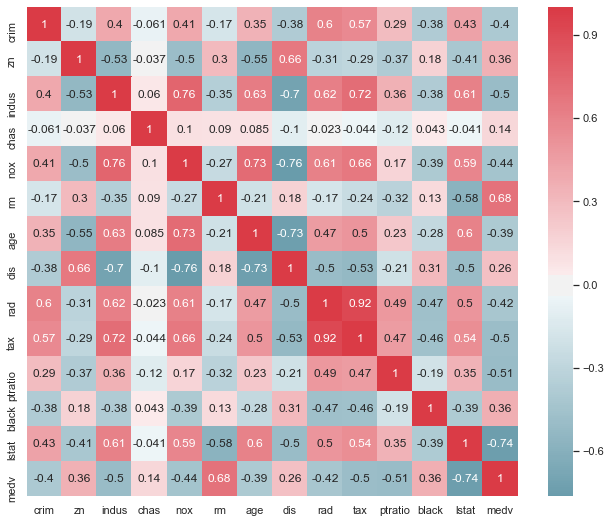

In [12]:
sns.set(color_codes = False)

corr = boston.corr()

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, cmap = cmap, center = 0, annot = True)

plt.show()

In [13]:
# lsat and ptratio have a high negative correlation

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [14]:
boston['medv'].describe()[['min','max','mean','50%','std']]

min      5.000000
max     50.000000
mean    22.312376
50%     21.400000
std      8.837019
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [48]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """

    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [49]:
from sklearn.model_selection import train_test_split

X = boston.drop('medv', axis = 'columns')
y = boston['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 29, shuffle = True)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [60]:
from sklearn.ensemble import RandomForestRegressor

max_depth = [2, 4, 6, 8, 10]

def forest_regr(max_d):
    regr = RandomForestRegressor(max_depth = max_d)
    regr.fit(X_train, y_train)
    accuracy_score = regr.score(X_test, y_test)
    return accuracy_score

accuracy_scores = [forest_regr(d) for d in max_depth]
accuracy_scores

/Users/marie/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/marie/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/marie/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/marie/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/marie/anaconda3/lib/python3.7/site-pa

[0.6878942245367173,
 0.7833136811098023,
 0.8200014837629748,
 0.83260299747809,
 0.7780347615704011]

Now, plot the score for each tree on the training set and on the testing set.

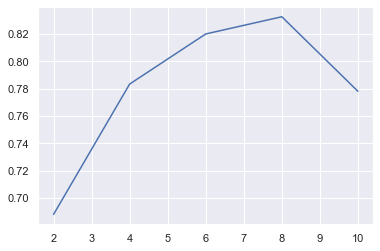

In [61]:
plt.plot(max_d, accuracy_scores)
plt.show()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [19]:
# 

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

In [64]:
print("Maximum depth of 1:", forest_regr(1), '  Maximum depth of 10:', forest_regr(10))

Maximum depth of 1: 0.506424324847687   Maximum depth of 10: 0.8066216744574977


/Users/marie/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/marie/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*